In [1]:
import zipfile
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-18 09:32:05.147192: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 09:32:06.271012: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 09:32:08.693303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 09:32:10.732404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Machine learning

In [2]:
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [3]:
# Define paths
extracted_directory = "./trafficsigns_dataset"
train_directory = "./train_data"
val_directory = "./val_data"
test_directory = "./test_data"

# Create train, validation, and test directories if they don't exist
for directory in [train_directory, val_directory, test_directory]:
    os.makedirs(directory, exist_ok=True)

# Function to split data into train, validation, and test
def split_data(source, train, val, test, split_ratio):
    for shape_folder in os.listdir(source):
        if shape_folder in ['.DS_Store', 'Readme.txt']:
            continue  # Ignore non-image files
        shape_source = os.path.join(source, shape_folder)
        shape_train = os.path.join(train, shape_folder)
        shape_val = os.path.join(val, shape_folder)
        shape_test = os.path.join(test, shape_folder)
        
        for folder in [shape_train, shape_val, shape_test]:
            os.makedirs(folder, exist_ok=True)
        
        for type_folder in os.listdir(shape_source):
            if type_folder in ['.DS_Store', 'Readme.txt']:
                continue  # Ignore non-image files
            type_source = os.path.join(shape_source, type_folder)
            type_train = os.path.join(shape_train, type_folder)
            type_val = os.path.join(shape_val, type_folder)
            type_test = os.path.join(shape_test, type_folder)
            
            for folder in [type_train, type_val, type_test]:
                os.makedirs(folder, exist_ok=True)
            
            files = os.listdir(type_source)
            train_files, test_files = train_test_split(files, test_size=split_ratio[2], random_state=42)
            train_files, val_files = train_test_split(train_files, test_size=split_ratio[1]/(split_ratio[0]+split_ratio[1]), random_state=42)
            
            # Copy files to train, validation, and test directories
            for file in train_files:
                shutil.copy(os.path.join(type_source, file), os.path.join(type_train, file))
            
            for file in val_files:
                shutil.copy(os.path.join(type_source, file), os.path.join(type_val, file))
                
            for file in test_files:
                shutil.copy(os.path.join(type_source, file), os.path.join(type_test, file))

# Split data into train, validation, and test with 60-20-20 split ratio
split_ratio = [0.6, 0.2, 0.2]
split_data(extracted_directory, train_directory, val_directory, test_directory, split_ratio)

print("Data split completed successfully.")


Data split completed successfully.


In [4]:
def get_data_shape(directory):
    num_samples = 0
    for root, dirs, files in os.walk(directory):
        num_samples += len(files)
    return num_samples

# Get the shape of training, validation, and testing sets
train_shape = get_data_shape(train_directory)
val_shape = get_data_shape(val_directory)
test_shape = get_data_shape(test_directory)

# Get total number of images
total_images = train_shape + val_shape + test_shape

print("Training Set Shape:", train_shape)
print("Validation Set Shape:", val_shape)
print("Testing Set Shape:", test_shape)
print("Total Number of Images:", total_images)


Training Set Shape: 2212
Validation Set Shape: 742
Testing Set Shape: 746
Total Number of Images: 3700


Training Set Samples:


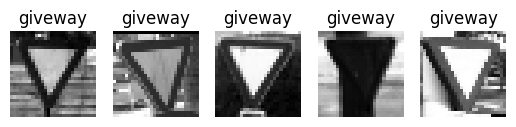

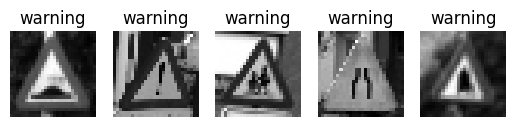

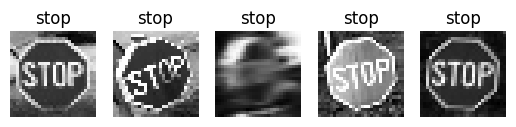

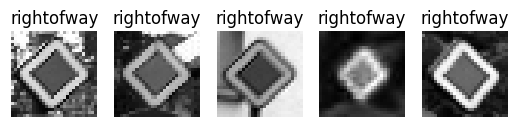

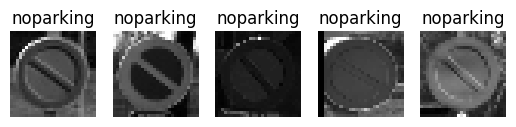

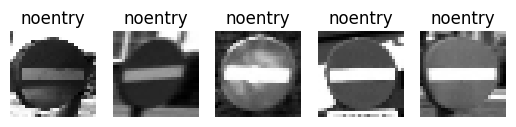

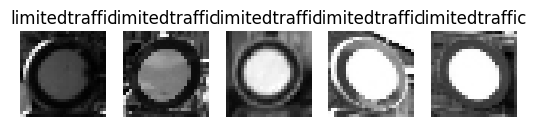

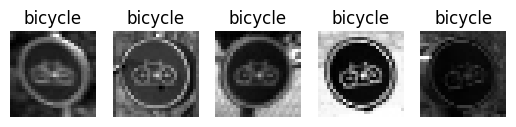

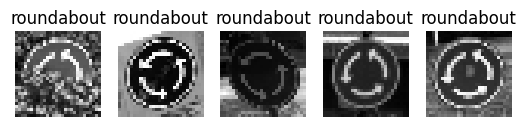

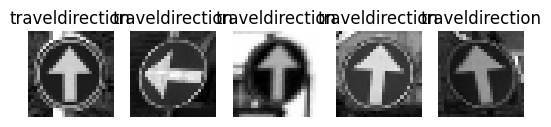

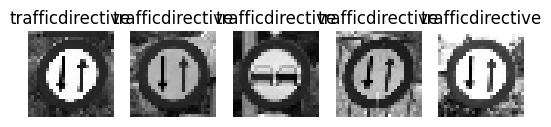

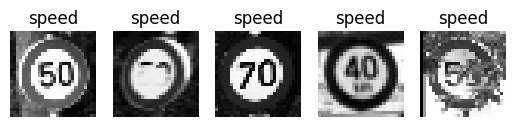

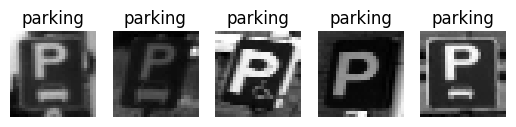

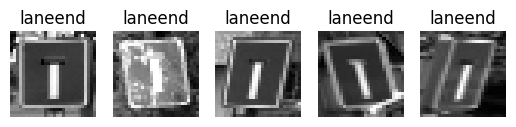

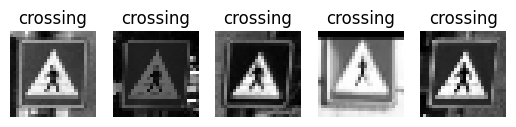

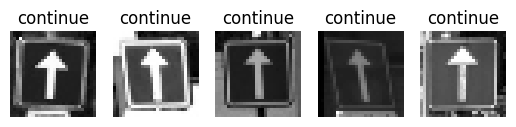

Validation Set Samples:


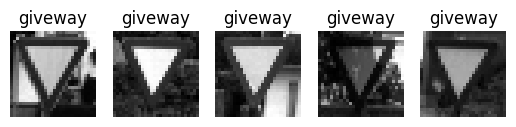

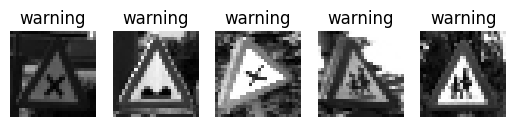

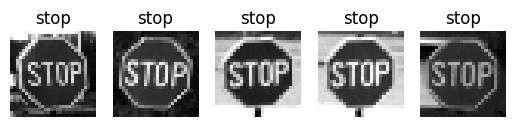

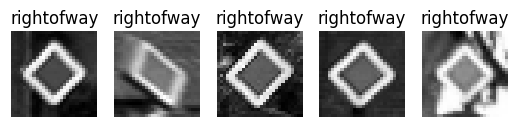

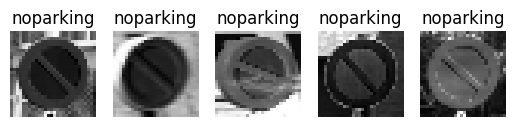

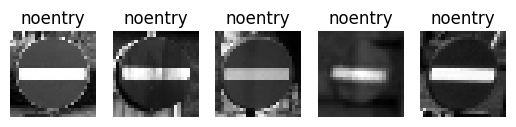

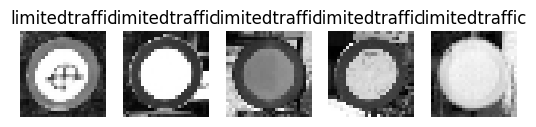

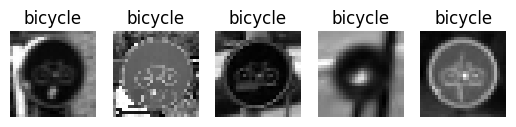

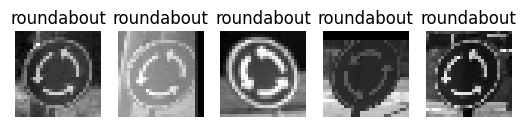

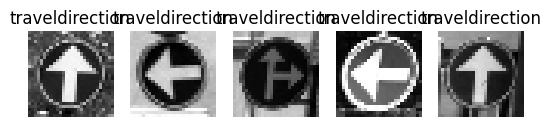

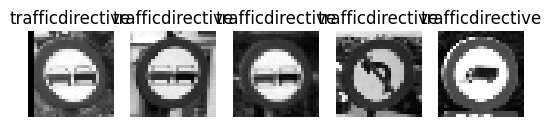

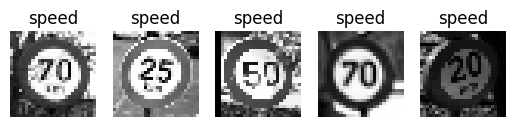

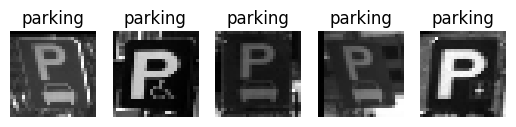

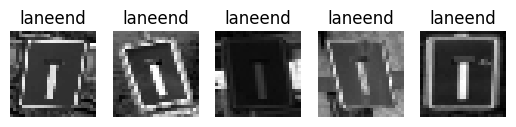

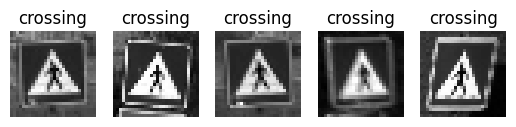

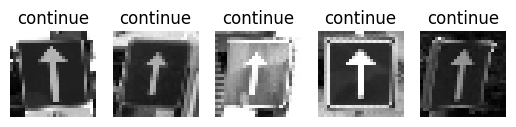

Testing Set Samples:


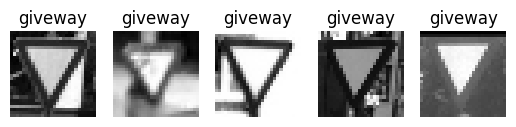

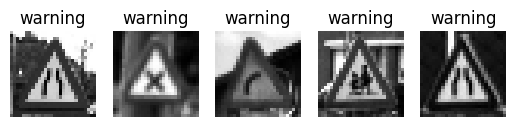

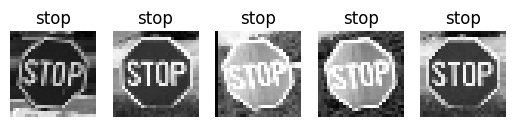

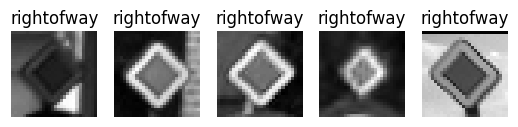

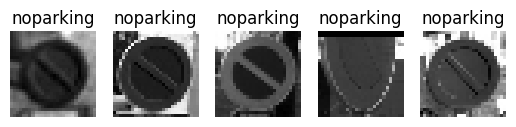

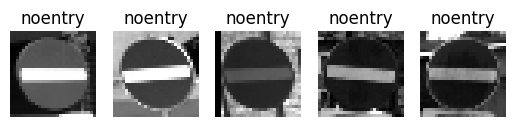

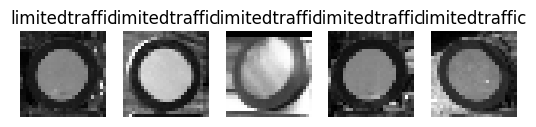

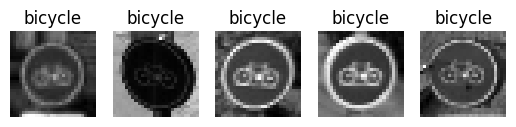

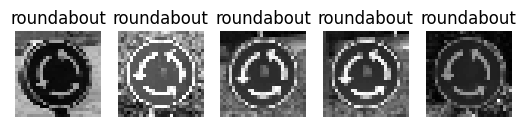

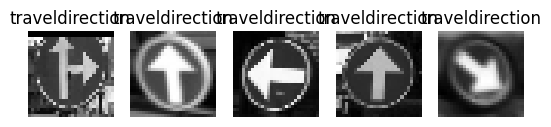

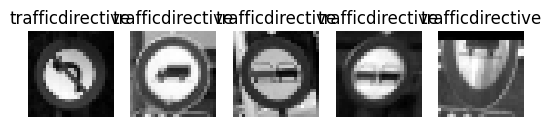

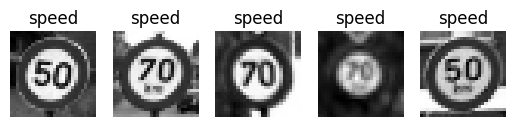

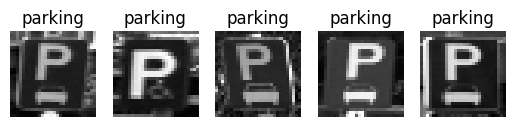

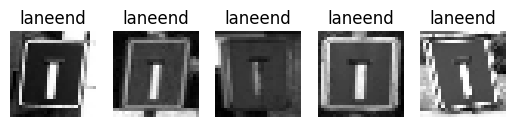

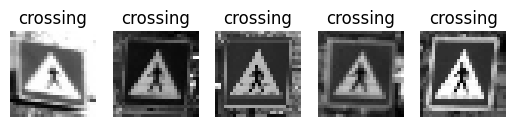

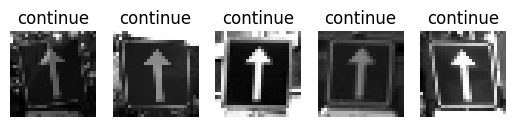

In [5]:
def display_random_samples(directory, num_samples=5):
    for shape_folder in os.listdir(directory):
        shape_directory = os.path.join(directory, shape_folder)
        if os.path.isdir(shape_directory):  # Check if it's a directory
            for type_folder in os.listdir(shape_directory):
                type_directory = os.path.join(shape_directory, type_folder)
                if os.path.isdir(type_directory):  # Check if it's a directory
                    files = os.listdir(type_directory)
                    files = [f for f in files if not f.startswith('.')]  # Filter out hidden files
                    if len(files) < num_samples:
                        num_samples = len(files)  # Adjust num_samples if fewer files available
                    random_files = random.sample(files, num_samples)  # Randomly select num_samples files
                    for i, file in enumerate(random_files):  # Enumerate over the randomly selected files
                        file_path = os.path.join(type_directory, file)
                        img = mpimg.imread(file_path)
                        plt.subplot(1, num_samples, i+1)
                        plt.imshow(img, cmap='gray')  # Specify 'gray' colormap for grayscale display
                        plt.axis('off')
                        plt.title(os.path.basename(type_directory))
                    plt.show()  # Show the plot after the loop

# Display random samples from training, validation, and testing sets
print("Training Set Samples:")
display_random_samples(train_directory)
print("Validation Set Samples:")
display_random_samples(val_directory)
print("Testing Set Samples:")
display_random_samples(test_directory)


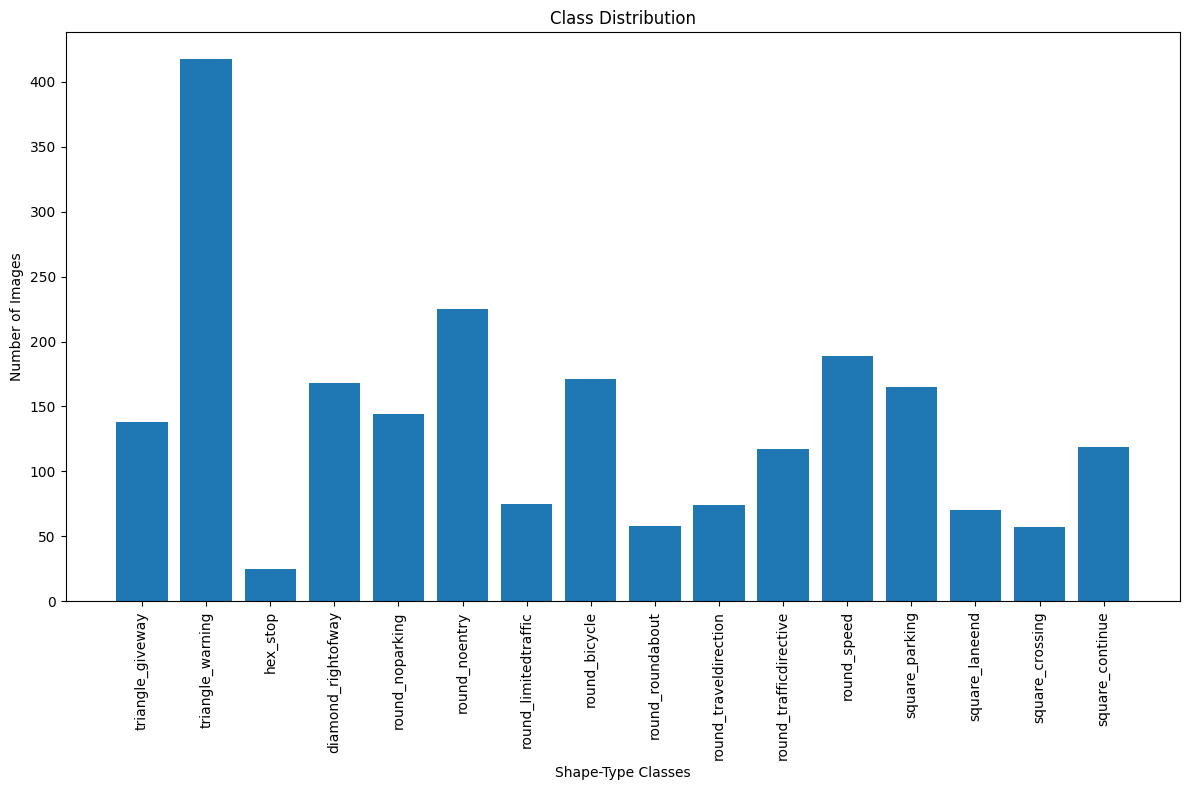

Total number of classes: 16


In [6]:
# Define paths to train data
train_directory = "./train_data"

# Get list of shape classes (shape types)
shape_classes = os.listdir(train_directory)

# Dictionary to store counts of images per shape and type combination
class_counts = {}

# Iterate over shape classes (shape types)
for shape_class in shape_classes:
    shape_class_dir = os.path.join(train_directory, shape_class)
    # Get list of type classes for each shape class
    type_classes = os.listdir(shape_class_dir)
    # Iterate over type classes
    for type_class in type_classes:
        type_class_dir = os.path.join(shape_class_dir, type_class)
        # Count the number of images in each shape and type combination class directory
        class_name = f"{shape_class}_{type_class}"  # Combine shape and type class names
        class_counts[class_name] = sum(len(files) for _, _, files in os.walk(type_class_dir))

# Plot class distribution
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_counts)), list(class_counts.values()), align='center')
plt.xticks(range(len(class_counts)), list(class_counts.keys()), rotation=90)
plt.xlabel('Shape-Type Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

print("Total number of classes:", len(class_counts))


In [7]:
# Print count of each class
print("Class distribution")
for class_name, count in class_counts.items():
    print(class_name,":", count)

Class distribution
triangle_giveway : 138
hex_stop : 25
diamond_rightofway : 168
round_noparking : 144
round_noentry : 225
round_limitedtraffic : 75
round_bicycle : 171
round_roundabout : 58
round_traveldirection : 74
round_trafficdirective : 117
round_speed : 189
square_parking : 165
square_laneend : 70
square_crossing : 57
square_continue : 119


In [8]:
#TO DELETE DIRECTORIES

# import shutil

# # Define paths
# train_directory = "./train_data"
# val_directory = "./val_data"
# test_directory = "./test_data"

# # Function to delete directories
# def delete_directories(*directories):
#     for directory in directories:
#         shutil.rmtree(directory, ignore_errors=True)

# # Delete train, val, and test directories
# delete_directories(train_directory, val_directory, test_directory)

# print("Directories deleted successfully.")


In [9]:
# model construction
def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Assuming class_counts is already defined as the number of classes
num_classes = len(class_counts)
model = build_model(num_classes)
model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,320 (946.56 KB)

 Trainable params: 242,320 (946.56 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define data generators with augmentation for training and only rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
def get_image_paths_and_labels(base_directory):
    image_paths = []
    labels = []
    label_dict = {}

    # Assign a numeric label to each type within each shape
    current_label = 0
    for shape in os.listdir(base_directory):
        shape_path = os.path.join(base_directory, shape)
        if os.path.isdir(shape_path):
            for sign_type in os.listdir(shape_path):
                type_path = os.path.join(shape_path, sign_type)
                if os.path.isdir(type_path):
                    if sign_type not in label_dict:
                        label_dict[sign_type] = current_label
                        current_label += 1
                    for image_name in os.listdir(type_path):
                        image_path = os.path.join(type_path, image_name)
                        image_paths.append(image_path)
                        labels.append(label_dict[sign_type])
    return image_paths, labels, label_dict

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # Resize the image to the desired size
    return tf.image.resize(img, [28, 28])

def process_path(file_path, label):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Base directory
base_directory = "./trafficsigns_dataset"

# Get image paths and labels
image_paths, labels, label_dict = get_image_paths_and_labels(base_directory)

# Create Dataset
path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
image_label_ds = path_ds.map(process_path)

# Batch and shuffle
batch_size = 32
image_label_ds = image_label_ds.shuffle(buffer_size=1000).batch(batch_size)

# Now you can use image_label_ds in your model training

In [12]:
def get_classes(directory):
    """
    This function navigates through the directory structure and retrieves unique shape and type classes.
    Assumes the following structure:
    directory/
        shape1/
            type1/
            type2/
        shape2/
            type1/
            type2/
    """
    shape_classes = []
    type_classes = set()  # Use a set to avoid duplicates

    # Iterate through each item in the root directory
    for shape in os.listdir(directory):
        shape_path = os.path.join(directory, shape)
        if os.path.isdir(shape_path):
            shape_classes.append(shape)
            # Now explore each shape directory for types
            for type_ in os.listdir(shape_path):
                type_path = os.path.join(shape_path, type_)
                if os.path.isdir(type_path):
                    type_classes.add(type_)  # Add type to the set

    return shape_classes, list(type_classes)  # Convert type_classes set to list

# Directory where extracted data is stored
extracted_directory = "./trafficsigns_dataset"

# Get shape and type classes
shape_classes, type_classes = get_classes(extracted_directory)

print("Shape Classes Found:",shape_classes)
print("Type Classes Found:",type_classes)

Shape Classes Found: ['triangle', 'hex', 'diamond', 'round', 'square']
Type Classes Found: ['crossing', 'giveway', 'noparking', 'trafficdirective', 'stop', 'limitedtraffic', 'traveldirection', 'speed', 'continue', 'bicycle', 'laneend', 'parking', 'warning', 'rightofway', 'roundabout', 'noentry']


In [13]:
def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath, topdown=True):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        if files:
            print(subindent + f'{len(files)} files')

# Adjust the path to match where your data is stored
print_directory_structure('./trafficsigns_dataset')

trafficsigns_dataset/
    2 files
    triangle/
        giveway/
            231 files
        warning/
            696 files
    hex/
        stop/
            43 files
    diamond/
        rightofway/
            282 files
    round/
        1 files
        noparking/
            242 files
        noentry/
            375 files
        limitedtraffic/
            125 files
        bicycle/
            285 files
        roundabout/
            98 files
        traveldirection/
            124 files
        trafficdirective/
            195 files
        speed/
            316 files
    square/
        1 files
        parking/
            276 files
        laneend/
            118 files
        crossing/
            95 files
        continue/
            199 files


In [17]:
# Data generator setup for shape classification
train_shape_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse',
    classes=shape_classes  # Ensure that only shape directories are targeted
)

val_shape_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse',
    classes=shape_classes
)

# Assuming that type_classes is a list of all traffic sign types
train_type_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse',
    classes=type_classes  # Ensure that only type directories are targeted
)

val_type_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse',
    classes=type_classes
)

Found 2212 images belonging to 5 classes.
Found 741 images belonging to 5 classes.
Found 0 images belonging to 16 classes.
Found 0 images belonging to 16 classes.


In [15]:
# Assuming shape_classes and type_classes have been defined as shown in the previous example
num_shape_classes = len(shape_classes)
num_type_classes = len(type_classes)

# Build models for each classification task
shape_model = build_model(num_shape_classes)
type_model = build_model(num_type_classes)

# Train shape model
shape_history = shape_model.fit(
    train_shape_generator,
    validation_data=val_shape_generator,
    epochs=10,
    steps_per_epoch=train_shape_generator.samples // train_shape_generator.batch_size,
    validation_steps=val_shape_generator.samples // val_shape_generator.batch_size
)

# Train type model
type_history = type_model.fit(
    train_type_generator,
    validation_data=val_type_generator,
    epochs=10,
    steps_per_epoch=train_type_generator.samples // train_type_generator.batch_size,
    validation_steps=val_type_generator.samples // val_type_generator.batch_size
)

Epoch 1/10


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/69 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3184 - loss: 1.5570

2024-05-18 09:32:31.402236: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20321280 exceeds 10% of free system memory.
2024-05-18 09:32:31.407952: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20321280 exceeds 10% of free system memory.
2024-05-18 09:32:31.445586: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20321280 exceeds 10% of free system memory.
2024-05-18 09:32:31.449560: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20321280 exceeds 10% of free system memory.
2024-05-18 09:32:31.484539: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20321280 exceeds 10% of free system memory.


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4441 - loss: 1.3867 - val_accuracy: 0.4728 - val_loss: 1.2380
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.3750 - loss: 1.2486 - val_accuracy: 1.0000 - val_loss: 0.7958
Epoch 3/10


2024-05-18 09:32:34.626953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/codespace/.python/current/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-18 09:32:34.637690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4943 - loss: 1.2504 - val_accuracy: 0.6168 - val_loss: 1.0097
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.4375 - loss: 1.2536 - val_accuracy: 0.4000 - val_loss: 1.1768
Epoch 5/10


2024-05-18 09:32:39.321409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 09:32:39.330571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5640 - loss: 1.1051 - val_accuracy: 0.7473 - val_loss: 0.7739
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.4375 - loss: 1.2326 - val_accuracy: 0.6000 - val_loss: 0.7925
Epoch 7/10


2024-05-18 09:32:44.418087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 09:32:44.425496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6455 - loss: 0.9755 - val_accuracy: 0.7595 - val_loss: 0.6501
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6562 - loss: 0.9841 - val_accuracy: 0.8000 - val_loss: 1.5316
Epoch 9/10


2024-05-18 09:32:49.532430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 09:32:49.544099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6899 - loss: 0.8393 - val_accuracy: 0.8777 - val_loss: 0.5234
Epoch 10/10
 1/69 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7500 - loss: 0.7257

2024-05-18 09:32:54.626499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 09:32:54.631913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.7257 - val_accuracy: 0.8000 - val_loss: 0.4903


ValueError: Must provide at least one structure

In [ ]:
# Evaluate both models on their respective test sets
shape_test_accuracy = shape_model.evaluate(test_shape_generator)
type_test_accuracy = type_model.evaluate(test_type_generator)

print(f"Shape Classification Test Accuracy: {shape_test_accuracy[1]*100:.2f}%")
print(f"Type Classification Test Accuracy: {type_test_accuracy[1]*100:.2f}%")

In [ ]:
# Function to plot training history
def plot_training_history(history, title="Training and Validation Accuracy"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plotting the training and validation history for both models
plot_training_history(shape_history, "Shape Classification Accuracy")
plot_training_history(type_history, "Type Classification Accuracy")